In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


In [48]:
import math
import os
import pickle
import random
from datetime import datetime

import numpy as np
import torch
from matplotlib import pyplot as plt
from music21 import converter
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from IPython.display import display, Audio

from utils import decode_midi

In [49]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [50]:
torch.manual_seed(0);

## Data processing

In [51]:
DATA_ROOT = "data/pop_pickle"
N_SAMPLES = 909
VOCAB_SIZE = 390
BOS_TOKEN = VOCAB_SIZE - 2
PAD_TOKEN = VOCAB_SIZE - 1

In [52]:
dataset = []
for i in range(N_SAMPLES):
    file_name = str(i + 1).zfill(3) + ".pickle"
    path = os.path.join(DATA_ROOT, file_name)
    with open(path, "rb") as f:
        seq = pickle.load(f)
        seq_tensor = torch.LongTensor(seq)
    dataset.append(seq_tensor)

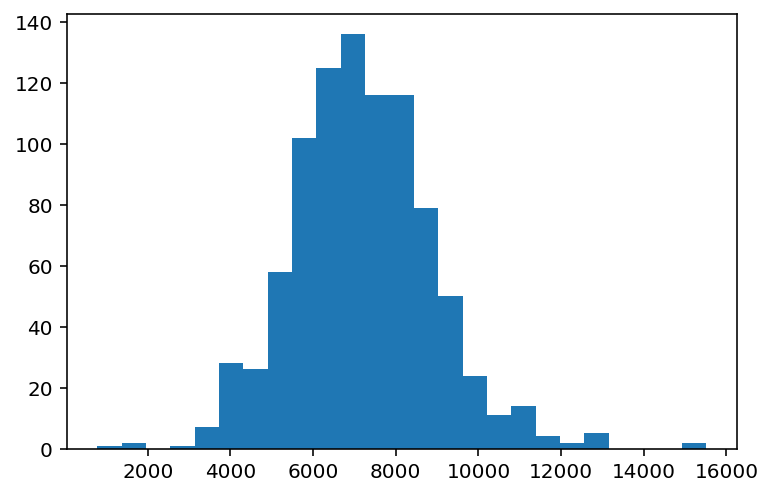

In [53]:
seq_lens = [len(seq) for seq in dataset]

plt.figure()
plt.hist(seq_lens, bins=25)
plt.show()

In [54]:
N_VAL = N_TEST = int(0.05 * 909)
N_TRAIN = 909 - (N_VAL + N_TEST)

train_songs = dataset[:N_TRAIN]
val_songs = dataset[N_TRAIN:N_TRAIN+N_VAL]
test_songs = dataset[N_TRAIN+N_VAL:]

print(f"Train: {len(train_songs)} \t Val: {len(val_songs)} \t Test: {len(test_songs)}")

Train: 819 	 Val: 45 	 Test: 45


In [55]:
def batchify(seq, new_seq_len):
    """
    Convert a sequence into a batch of equal-length sequences,
    and prepend a BOS token at the start of every sequence.
    
    Unless new_seq_len perfectly divides the number of tokens
    in seq, the last sequence will be padded with PAD_TOKENs.
    """
    n = seq.numel() % new_seq_len
    pad_size = 0 if n == 0 else new_seq_len - n
    pad = torch.full(size=(pad_size,), fill_value=PAD_TOKEN)
    seq = torch.cat([seq, pad])
    assert seq.numel() % new_seq_len == 0
    num_batches = int(seq.numel() / new_seq_len)
    batch = seq.view(num_batches, -1)
    bos = torch.full(size=(num_batches, 1), fill_value=BOS_TOKEN)
    batch = torch.cat([bos, batch], dim=1)    
    return batch

In [56]:
SEQ_LEN = 1024

train_data = torch.cat([batchify(seq, SEQ_LEN) for seq in train_songs])
val_data = torch.cat([batchify(seq, SEQ_LEN) for seq in val_songs])
test_data = torch.cat([batchify(seq, SEQ_LEN) for seq in test_songs])

print(f"Train: {len(train_data)} \t Val: {len(val_data)} \t Test: {len(test_data)}")

Train: 6166 	 Val: 355 	 Test: 336


## Training an LSTM model

In [57]:
class MusicRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, rnn_type="lstm", num_layers=1, dropout=0.0):
        assert rnn_type in ["lstm", "gru"]

        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.dropout = dropout

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == "lstm":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True) 
        else:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
        self.hidden_state = None

    def forward(self, x, reset_hidden_state=True):
        x = self.embeddings(x)
        if reset_hidden_state:
            x, _ = self.rnn(x)
        else:
            x, self.hidden_state = self.rnn(x, self.hidden_state)
        x = self.fc(x)
        return x

    def generate_sequence(self, beam_width=1, seq_start=None, max_length=1024, **kwargs):
        if not seq_start:
            seq_start = [BOS_TOKEN]
        seq = seq_start.copy()
        with torch.no_grad():
            # Generate k most likely tokens
            prev_top_seq, next_top_seq = [], []
            prev_top_seq = [(seq, 0.0)]
            
            import pdb;
            pdb.set_trace()
            
            kpos_next_tokens = self._generate_next_token(
                candidates=torch.LongTensor(seq).to(device),
                reset_hidden=True,
                **kwargs
            )
            
            next_top_seq.extend(kpos_next_tokens)
            
            while len(seq) <= max_length:
                for sequence in prev_top_seq:
                    kpos_next_tokens = self._generate_next_token(
                        candidates=torch.LongTensor([kpos_next_tokens]).to(device),
                        reset_hidden=False,
                        **kwargs
                    )
                    
                    next_top_seq.extend(kpos_next_tokens)
                
                next_top_seq.sort(reverse=True, key=lambda tup: tup[1])
                prev_top_seq = next_top_seq[:self.beam_width]
                next_top_seq = []
                
                seq.append(next_token)
        
        n = min(len(prev_top_seq), max_length)
        return prev_top_seq[:n]
    
    def _generate_next_token(self, candidates, reset_hidden=False, temp=1.0, topk=5, argmax=False):
        # The model expects a batch input, so we add a fake batch dimension.
        # Removed the fake batch dimension (.unsqueeze(0)) because we have batch of beam_width tokens
        model_input = np.array([tup[0] for tup in candidates]) # Previous sequences: [(seq , score), (seq2, score), (seq3, score)]
        # Then, we need to remove the fake batch dimension from the output.
        # Also removed the (.squeeze(0)) for similar reasons
        model_output = self(model_input, reset_hidden)
        
        # Apply softmax to top beam_width tokens
        
        for i in range(len(candidates)):
            next_token_probs = [(candidates[i].first + token, candidates[i].second + np.log(score)) for score in F.softmax(model_output[:, i] / temp, dim=0)]
        
        if argmax:
            # Keep top beam_width tokens
            kpos_next_tokens = torch.topk(next_token_probs, self.beam_width)
        else:
            # TO-DO: Implement beam search for this case too
            top_tokens = torch.topk(next_token_probs, topk)
            top_indices = top_tokens.indices
            top_probs = top_tokens.values
            top_probs /= torch.sum(top_probs)
            kpos_next_tokens = np.random.choice(top_indices.cpu().numpy(), p=top_probs.cpu().numpy())
        return kpos_next_tokens

In [58]:
def validate(model, data_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for batch in data_loader:
            batch = batch.to(device)
            x = batch[:, :-1]
            y = batch[:, 1:]
            y_hat = model(x)
            y_hat = y_hat.transpose(1, 2)
            loss = loss_function(y_hat, y)
            total_loss += loss.item()
        ppl = math.exp(total_loss / len(data_loader))
        return ppl

def remove_special_tokens(seq):
    return [token for token in seq if token not in [BOS_TOKEN, PAD_TOKEN]]

def display_audio(seq):
    seq = remove_special_tokens(seq)
    decode_midi(seq, "data/music_out/tmp.mid")
    stream = converter.parse("data/music_out/tmp.mid")
    stream.show("midi")

In [59]:
NUM_LAYERS = 1
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_EPOCHS = 250
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
CLIPPING_THRESHOLD = 1.0
DROPOUT = 0.0

LOG_EVERY_N = 1
VAL_EVERY_N = 10
SAVE_EVERY_N = 10

In [60]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=torch.stack,
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=torch.stack,
)

In [61]:
model = MusicRNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [62]:
print(model)

MusicRNN(
  (embeddings): Embedding(390, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=390, bias=True)
)


In [63]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M")
exp_name = (
    f"{model.rnn_type}({EMBEDDING_DIM},{HIDDEN_DIM}),"
    f"lr={LEARNING_RATE},bsz={BATCH_SIZE},nepochs={NUM_EPOCHS},"
    f"sl={SEQ_LEN},dropout={DROPOUT},t={now}"
)
writer = SummaryWriter(f"runs/test")

In [35]:
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader):
        # Move to GPU if available.
        batch = batch.to(device)

        # Reset gradients.
        model.zero_grad()

        # Prepare inputs and targets.
        x = batch[:, :-1]
        y = batch[:, 1:]
                
        # Forward prop.
        y_hat = model(x)
        
        # Swap token dim and output dim.
        y_hat = y_hat.transpose(1, 2)
        
        # Compute loss.
        loss = loss_function(y_hat, y)
        total_loss += loss.item()

        # Back prop.
        loss.backward()
        
        # Clip gradients.
        clip_grad_norm_(model.parameters(), CLIPPING_THRESHOLD)
        
        # Update parameters.
        optimizer.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(train_loader)  # per token loss
        writer.add_scalar("train_loss", avg_loss, global_step=epoch)
        
        train_ppl = math.exp(avg_loss)
        writer.add_scalar("train_ppl", train_ppl, global_step=epoch)

    if epoch % VAL_EVERY_N == 0:
        val_ppl = validate(model, val_loader)
        writer.add_scalar("val_ppl", val_ppl, global_step=epoch)
        seq = model.generate_sequence(temp=1.0, topk=32)
        display_audio(seq)

    if epoch % SAVE_EVERY_N == 0:
        state_checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(state_checkpoint, f"models/lstm_checkpoints/ckpt_{epoch}.pt")

KeyboardInterrupt: 

## Training a transformer model

In [152]:
import time

from music_transformer import custom
from music_transformer import utils
from music_transformer.custom.metrics import *
from music_transformer.custom.criterion import SmoothCrossEntropyLoss, CustomSchedule
from music_transformer.custom.config import config
from music_transformer.data import Data
from music_transformer.model import MusicTransformer

In [153]:
def validate_transformer(transformer, data_loader):
    transformer.eval()
    val_loss = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    with torch.no_grad():
        total_loss = 0.0
        for batch in data_loader:
            batch = batch.to(device)
            x = batch[:, :-1]
            y = batch[:, 1:]
            y_hat = transformer(x).transpose(1, 2)
            loss = val_loss(y_hat, y)
            total_loss += loss.item()
        ppl = math.exp(total_loss / len(data_loader))
        return ppl

In [161]:
NUM_LAYERS = 4
EMBEDDING_DIM = 256
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
BATCH_SIZE = 8
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1

LOG_EVERY_N = 1
VAL_EVERY_N = 2
SAVE_EVERY_N = 10

In [155]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=torch.stack,
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=torch.stack,
)

In [157]:
transformer = MusicTransformer(
    embedding_dim=EMBEDDING_DIM,
    vocab_size=VOCAB_SIZE,
    num_layer=NUM_LAYERS,
    max_seq=SEQ_LEN,
    dropout=DROPOUT,
).to(device)

print(transformer)

MusicTransformer(
  (Decoder): Encoder(
    (embedding): Embedding(390, 256)
    (pos_encoding): DynamicPositionEmbedding()
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (rga): RelativeGlobalAttention(
          (Wq): Linear(in_features=256, out_features=256, bias=True)
          (Wk): Linear(in_features=256, out_features=256, bias=True)
          (Wv): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
        )
        (FFN_pre): Linear(in_features=256, out_features=128, bias=True)
        (FFN_suf): Linear(in_features=128, out_features=256, bias=True)
        (layernorm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (layernorm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (rga): RelativeGlobalAttention(
          (Wq): Linear(in_

In [158]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = CustomSchedule(EMBEDDING_DIM, optimizer=optimizer)
loss_function = SmoothCrossEntropyLoss(LABEL_SMOOTHING, VOCAB_SIZE, PAD_TOKEN)
val_loss = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

In [159]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M")
exp_name = (
    f"Transformer({EMBEDDING_DIM},{VOCAB_SIZE},{NUM_LAYERS}),"
    f"lr={LEARNING_RATE},bsz={BATCH_SIZE},nepochs={NUM_EPOCHS},"
    f"sl={SEQ_LEN},dropout={DROPOUT},t={now}"
)
writer = SummaryWriter(f"runs/{exp_name}")

In [210]:
for epoch in range(NUM_EPOCHS):
    transformer.train()
    total_loss = 0.0
    for batch in tqdm(train_loader):
        # Move to GPU if available.
        batch = batch.to(device)

        # Reset gradients.
        transformer.zero_grad()
        
        # Prepare inputs and targets.
        x = batch[:, :-1]
        y = batch[:, 1:]

        # Forward prop.
        y_hat = transformer(x)

        loss = loss_function(y_hat, y)
        total_loss += loss.item()
        
        # Back prop.
        loss.backward()

        # Step scheduler (and optimizer).
        scheduler.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(train_loader)  # per token loss
        writer.add_scalar("train_loss", avg_loss, global_step=epoch)
    
    if epoch % VAL_EVERY_N == 0:
        ppl = validate_transformer(transformer, val_loader)
        writer.add_scalar("val_ppl", ppl, global_step=epoch)
        
        primer = torch.LongTensor([[BOS_TOKEN]]).to(device)
        seq = transformer.generate(primer, length=1024)
        display_audio(seq.tolist())

    if epoch % SAVE_EVERY_N == 0:
        state_checkpoint = {
            "epoch": epoch,
            "model_state_dict": transformer.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(state_checkpoint, f"models/checkpoints/ckpt_{epoch}.pt")

In [211]:
state_checkpoint = {
    "epoch": epoch,
    "model_state_dict": transformer.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}
torch.save(state_checkpoint, f"models/Transformer(256,390,4),lr=0.001,bsz=8,nepochs=1000,sl=1024,dropout=0.1,t=2020-11-14_12:52.pt")

## Model evaluation

## Generating music

In [65]:
lstm = MusicRNN(
    embedding_dim=64,
    hidden_dim=256,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=2,
    dropout=0.5,
).to(device)

sd = torch.load("models/lstm(64,256),lr=0.001,bsz=256,nepochs=250,sl=1024,dropout=0.5,t=2020-11-13_14:30.pt")["model_state_dict"]
lstm.load_state_dict(sd)

<All keys matched successfully>

In [37]:
FIRST_N = 125
IDX = 10

primer = test_songs[IDX][:FIRST_N].tolist()
display_audio(primer)

In [38]:
# primer = torch.LongTensor([[BOS_TOKEN]]).to(device)
primer = test_songs[IDX][:FIRST_N].unsqueeze(0).to(device)
seq = transformer.generate(primer, length=1024)
display_audio(seq.tolist())

NameError: name 'transformer' is not defined

In [66]:
primer = test_songs[IDX][:FIRST_N].tolist()
continuation = lstm.generate_sequence(primer, temp=1.0, topk=128)
display_audio(continuation)

> <ipython-input-57-07a2cea3d532>(44)generate_sequence()
-> kpos_next_tokens = self._generate_next_token(
(Pdb) n
> <ipython-input-57-07a2cea3d532>(45)generate_sequence()
-> candidates=torch.LongTensor(seq).to(device),
(Pdb) n
> <ipython-input-57-07a2cea3d532>(46)generate_sequence()
-> reset_hidden=True,
(Pdb) n
> <ipython-input-57-07a2cea3d532>(47)generate_sequence()
-> **kwargs
(Pdb) n
IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number
> <ipython-input-57-07a2cea3d532>(47)generate_sequence()
-> **kwargs
(Pdb) n
--Return--
> <ipython-input-57-07a2cea3d532>(47)generate_sequence()->None
-> **kwargs
(Pdb) n
IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number
> <ipython-input-66-4577b91f5022>(2)<module>()
-> continuation = lstm.generate_sequence(primer, temp=1.0, topk=128)
(Pdb) q


BdbQuit: 